In [59]:
# 方程式を定義
import numpy as np
import math
import functools
from scipy import integrate

def func_r(q, b):
    value = q / (1 - b + b * q) / (1 - b + b * q)
    return value

def func_f_integrand(z, m, q, a, b):
    r = func_r(q, b)
    if r < 0:
        return 0
    return math.exp(-z**2/2) * np.tanh(b * (m + math.sqrt(a*r) * z))

def func_f(m, q, a, b):
    func  = functools.partial(func_f_integrand, m=m, q=q, a=a, b=b)
    return m - (1 / math.sqrt(2 * np.pi)) * integrate.quad(func, -10.0, 10.0)[0]


def func_g_integrand(z, m, q, a, b):
    r = func_r(q, b)
    if r < 0:
        return 0
    return math.exp(-z**2/2) * np.tanh(b * (m + math.sqrt(a*r) * z)) ** 2

def func_g(m, q, a, b):
    func  = functools.partial(func_g_integrand, m=m, q=q, a=a, b=b)
    return q - (1 / math.sqrt(2 * np.pi)) * integrate.quad(func, -10.0, 10.0)[0]


def plot_f_and_g(plot_num, zlim, args, a, b):
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection='3d', zlim=(-1.0, 1.0))
    ax.set_title("f(m,q) & g(m,q)", size = 20)

    ax.set_xlabel("m", size = 20)
    ax.set_ylabel("q", size = 20)
    ax.set_zlabel("", size = 20)

    x = np.linspace(args["m_min"], args["m_max"], plot_num)
    y = np.linspace(args["q_min"], args["q_max"], plot_num)

    X, Y = np.meshgrid(x, y)
    X = X.flatten()
    Y = Y.flatten()
    
    F = np.ndarray([])
    G = np.ndarray([])
    for i in range(len(Y)-1):
        F = np.append(F, func_f(X[i], Y[i], a, b))
        G = np.append(G, func_g(X[i], Y[i], a, b))

    ax.plot(X, Y, F, color = "red", label='f (m,q)')
    ax.plot(X, Y, G, color = "green", label='g (m,q)')

    # これ呼ばないとラベルでない
    plt.legend()
    plt.show()


In [54]:
import numpy as np


def func_for_solve(x, a, b):
    return [
        func_f(x[0], x[1], a, b),
        func_g(x[0], x[1], a, b),
    ]

In [55]:
import matplotlib.pyplot as plt

# α=0の計算&グラフを書く
def solve_a_0_and_plot(solve_args):
    solver = Solver()

    solver.set_args(solve_args)
    solver.solve()
    solver.to_csv("a_0_by_mesh_method.csv")
    
#     print("solve args: {0}".format(solve_args))
    
    # グラフ
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111)

    ax.set_xlabel("T", size = 20)
    ax.set_ylabel("m", size = 20)

    # ニュートン法で解いたもの
    newton_method_solve = np.loadtxt("./a_0_newton.csv")

    newton_method_t = newton_method_solve[:, 0]
    newton_method_m = newton_method_solve[:, 1]

    ax.plot(newton_method_t, newton_method_m)

    # 本来の積分ありの方程式を解いたもの
    original_solve = np.loadtxt("./a_0_by_mesh_method.csv", delimiter=",")
    original_a = original_solve[:, 0]
    original_t = original_solve[:, 1]
    original_m = original_solve[:, 2]

    for i in range(len(original_m)):
        if original_a[i] == 0.0:
            ax.scatter(original_t[i], original_m[i], color = "red")
    
    plt.show()

In [56]:
import numpy as np
import csv
from scipy import optimize

# 解を見つけるためのクラス
class Solver:
    
    def __init__(self):
        pass
        
    def set_args(self, args):
        self.delta = args["delta"]
        self.func_1 = args["func_1"]
        self.func_2 = args["func_2"]
        self.debug = args["debug"]
        
        
        self.a_min = args["a_min"]
        self.a_max = args["a_max"]
        self.T_min = args["T_min"]
        self.T_max = args["T_max"]
        self.a_mesh_num = args["a_mesh_num"]
        self.T_mesh_num = args["T_mesh_num"]
        self.m_min = args["m_min"]
        self.m_max = args["m_max"]
        self.q_min = args["q_min"]
        self.q_max = args["q_max"]
        self.mq_mesh_num = args["mq_mesh_num"]
    
        
    def solve(self):
        A = np.linspace(self.a_min, self.a_max, self.a_mesh_num)
        T = np.linspace(self.T_min, self.T_max, self.T_mesh_num)
        a_arr, t_arr = np.meshgrid(A, T)
        self.a_arr = a_arr.flatten()
        self.T_arr = t_arr.flatten()
        
        self.m_answer_arr = []
        self.q_answer_arr = []
        
        for i in range(len(self.a_arr)):
            if self.debug:
                print("a={0}, T={1} \n".format(self.a_arr[i], self.T_arr[i]))
                print(result)
                print("\n"*2)
            func =  functools.partial(func_for_solve, a=self.a_arr[i], b=1/self.T_arr[i])
            result = optimize.root( func, [ 1.0, 1.0], method="broyden1")
        
            self.m_answer_arr.append(result.x[0] if result.x[0] >= 0 else -result.x[0])
            self.q_answer_arr.append(result.x[1])
        
        
    def to_csv(self, filename):
        f = open(filename, "w")
        writer = csv.writer(f)
        for i in range(len(self.a_arr)):
            tmp = [
                self.a_arr[i], 
                self.T_arr[i], 
                self.m_answer_arr[i], 
                self.q_answer_arr[i],
            ]
            writer.writerow(tmp)
        f.close()

c:\users\yamot\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\nonlin.py:472: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))
c:\users\yamot\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\nonlin.py:1016: RuntimeWarning: invalid value encountered in true_divide
  d = v / vdot(df, v)


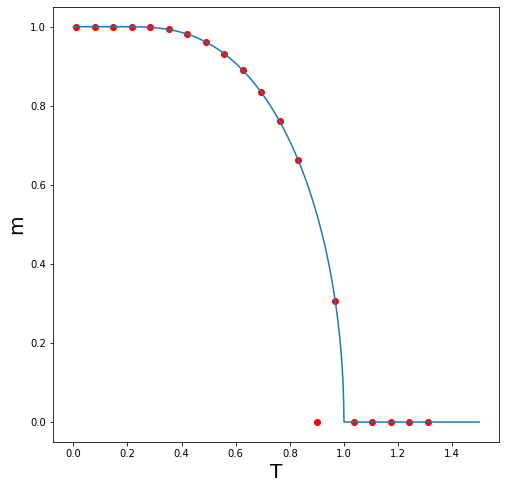

In [57]:
# α=0に絞って、パラメーターを調整する

default_solve_args = {
    # 調整すべきパラメータ
    "a_mesh_num": 1,
    "T_mesh_num": 20,
    "mq_mesh_num": 20,
    "delta": pow(10, -3),
    
    # 範囲系
    "a_min": 0,
    "a_max": 0.15,
    "T_min": 0.01,
    "T_max": 1.31,
    "m_min": 0,
    "m_max": 1,
    "q_min": 0,
    "q_max": 1,
    
    "func_1": func_f,
    "func_2": func_g,
    
    # デバッグ用(1にしたら色々出力される)
    "debug": 0,
}

solve_a_0_and_plot(default_solve_args)

# 実行時間: 約5s
# メッシュが荒すぎる or 解の条件が厳しすぎる???

In [65]:
# α=0に絞って、パラメーターを調整する

fitted_solve_args = {
    "mq_mesh_num": 100,
    "delta": pow(10, -2),
    
    "a_mesh_num": 50,
    "T_mesh_num": 50,
    "a_min": 0,
    "a_max": 0.15,
    "T_min": 0.01,
    "T_max": 1.50,
    "m_min": 0,
    "m_max": 1,
    "q_min": 0,
    "q_max": 1,
    
    "func_1": func_f,
    "func_2": func_g,
    
    "debug": 0,
}


solver = Solver()
solver.set_args(fitted_solve_args)
solver.solve()
solver.to_csv("solved_by_scipy.csv")

c:\users\yamot\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\nonlin.py:472: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))
c:\users\yamot\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\nonlin.py:1016: RuntimeWarning: invalid value encountered in true_divide
  d = v / vdot(df, v)
c:\users\yamot\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\nonlin.py:1016: RuntimeWarning: divide by zero encountered in true_divide
  d = v / vdot(df, v)


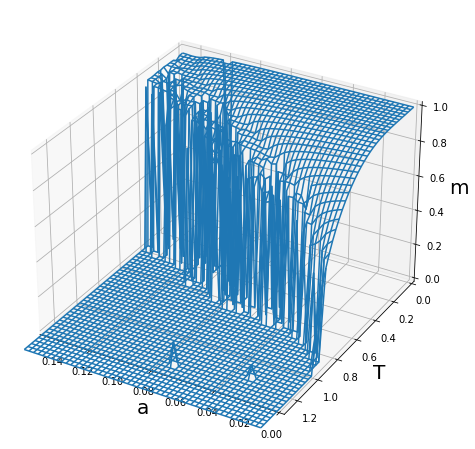

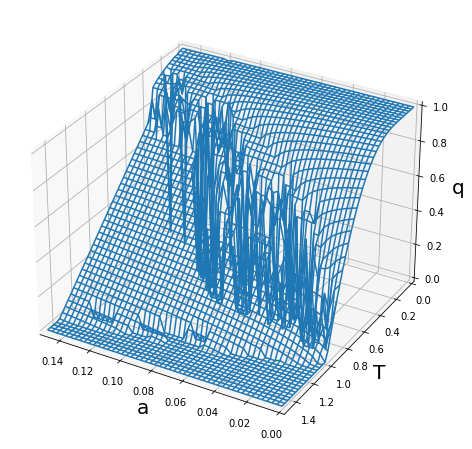

<Figure size 576x576 with 0 Axes>

In [69]:
from mpl_toolkits.mplot3d import Axes3D

def plot_scatter(_ax, result_a_1, result_t_1, result_z_1, debug=False):
    for i in range(len(result_a_1)):
        if debug:
            print(result_a_1[i], result_t_1[i], result_z_1[i])
        _ax.scatter(result_a_1[i], result_t_1[i], result_z_1[i], color = "red" if result_z_1[i]<0.1 else "green")

        
def plot_phase_diagram(filename):
    fig = plt.figure(figsize = (8, 8))
    
    ax_1 = fig.add_subplot(111, projection='3d')
    ax_1.set_xlabel("a", size = 20)
    ax_1.set_ylabel("T", size = 20)
    ax_1.set_zlabel("m", size = 20)
    ax_1.set_xlim(0.15, 0)
    ax_1.set_ylim(1.3, 0)
    
    
    fig = plt.figure(figsize = (8, 8))

    ax_2 = fig.add_subplot(111, projection='3d')
    ax_2.set_xlabel("a", size = 20)
    ax_2.set_ylabel("T", size = 20)
    ax_2.set_zlabel("q", size = 20)
    ax_2.set_xlim(0.15, 0)
    ax_2.set_ylim(1.50, 0)
    
    # グラフ
    fig = plt.figure(figsize = (8, 8))
#     ax = fig.add_subplot(111)

#     ax.set_xlabel("α", size = 20)
#     ax.set_ylabel("T", size = 20)

    original_solve = np.loadtxt(filename, delimiter=",")
    original_a = original_solve[:, 0]
    original_t = original_solve[:, 1]
    original_m = original_solve[:, 2]
    original_q = original_solve[:, 3]
    
    n = 50
    original_a_2d = np.array(np.array_split(original_a, n))
    original_t_2d = np.array(np.array_split(original_t, n))
    original_m_2d = np.array(np.array_split(original_m, n))
    original_q_2d = np.array(np.array_split(original_q, n))
    
    # 3Dグラフ
    # plot_surfaceで曲面
    # plot_wireframeでワイヤーフレーム
    ax_1.plot_wireframe(original_a_2d, original_t_2d, original_m_2d)
    ax_2.plot_wireframe(original_a_2d, original_t_2d, original_q_2d)


#     for i in range(len(original_a)):
#         color = "red" 
#         if original_m[i] > 0.15 and original_q[i] > 0.15:
#             color = "blue"
#         elif original_q[i] > 0.05:
#             color = "green"
#         ax.scatter(original_a[i], original_t[i], color=color)
    
    plt.show()

    
    
    
plot_phase_diagram("solved_by_scipy.csv")